In [3]:
import tensorflow as tf
import numpy as np

In [4]:
from tensorflow.python.client import device_lib

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17368052109441296811
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6285164544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10223291940107935241
 physical_device_desc: "device: 0, name: Quadro RTX 4000, pci bus id: 0000:65:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [6]:
import sys
assert sys.version_info >= (3, 7)

In [7]:
from packaging import version
assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [8]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

## Markov Decision Process

In [9]:
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

## Q-Value Iteration

In [10]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

gamma = 0.90  # the discount factor

for iteration in range(50):
    Q_prev = Q_values.copy()
    if iteration == 5:
        print(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            tmp = []
            for sp in range(3):
                sp_tmp = transition_probabilities[s][a][sp] * ( rewards[s][a][sp] + gamma * Q_prev[sp].max())
                if iteration == 5:
                    print(
                        sp, transition_probabilities[s][a][sp], 
                        rewards[s][a][sp], Q_prev[sp].max(), gamma * Q_prev[sp].max(),
                        rewards[s][a][sp] + gamma * Q_prev[sp].max(),
                        sp_tmp
                    )
                tmp.append(sp_tmp)
            Q_values[s, a] = np.sum(tmp)
            if iteration == 5:
                print(np.sum(tmp))
                print(s, a, '-->', Q_values)

[[17.04133627 14.3447661  11.47581288]
 [ 0.                -inf -8.4575336 ]
 [       -inf 47.63005952        -inf]]
0 0.7 10 17.04133627 15.337202643 25.337202642999998 17.736041850099998
1 0.3 0 0.0 0.0 0.0 0.0
2 0.0 0 47.63005952 42.867053568 42.867053568 0.0
17.736041850099998
0 0 --> [[17.73604185 14.3447661  11.47581288]
 [ 0.                -inf -8.4575336 ]
 [       -inf 47.63005952        -inf]]
0 1.0 0 17.04133627 15.337202643 15.337202643 15.337202643
1 0.0 0 0.0 0.0 0.0 0.0
2 0.0 0 47.63005952 42.867053568 42.867053568 0.0
15.337202643
0 1 --> [[17.73604185 15.33720264 11.47581288]
 [ 0.                -inf -8.4575336 ]
 [       -inf 47.63005952        -inf]]
0 0.8 0 17.04133627 15.337202643 15.337202643 12.2697621144
1 0.2 0 0.0 0.0 0.0 0.0
2 0.0 0 47.63005952 42.867053568 42.867053568 0.0
12.2697621144
0 2 --> [[17.73604185 15.33720264 12.26976211]
 [ 0.                -inf -8.4575336 ]
 [       -inf 47.63005952        -inf]]
0 0.0 0 17.04133627 15.337202643 15.337202643

In [11]:
Q_values = np.full((3, 3), -np.inf)
print(Q_values)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

print(Q_values)
gamma = 0.90  # the discount factor

history1 = []  # extra code – needed for the figure below
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)

    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                transition_probabilities[s][a][sp] * (
                    rewards[s][a][sp] + gamma * Q_prev[sp].max()
                )
                for sp in range(3)
            ])

[[-inf -inf -inf]
 [-inf -inf -inf]
 [-inf -inf -inf]]
[[  0.   0.   0.]
 [  0. -inf   0.]
 [-inf   0. -inf]]


In [12]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [13]:
Q_values.argmax(axis=1)

array([0, 0, 1], dtype=int64)

## Q-Learning

In [59]:
def step(state, action):
    probabs = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probabs)
    reward = rewards[state][action][next_state]
    return next_state, reward
    
def exploration_policy( state ):
    return np.random.choice(possible_actions[state])

In [60]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90  # discount factor
state = 0  # initial state
history2 = []  # extra code – needed for the figure below

In [61]:
for iteration in range(10_000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()
    alpha = alpha0/(1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

In [62]:
history1 = np.array(history1)  
history2 = np.array(history2)  

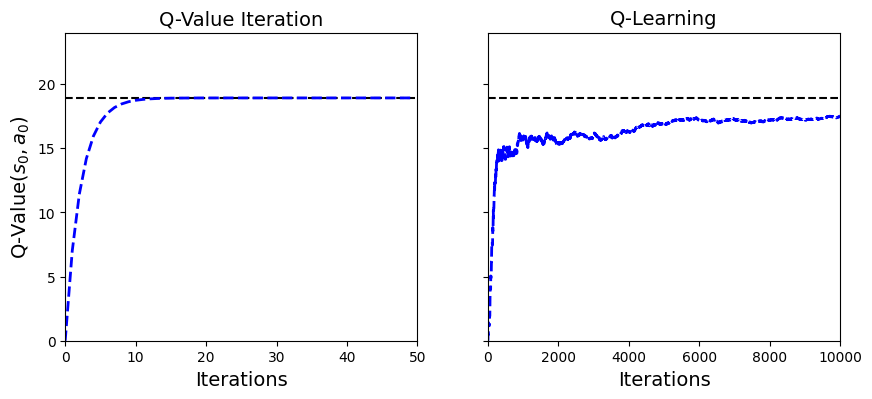

In [64]:
true_Q_value = history1[-1, 0, 0]

fix, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)

for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:,0,0], "b--", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    

## Deep Q-Network

In [14]:
import gymnasium as gym
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [15]:
from collections import deque
replay_buffer = deque(maxlen=2000)

In [16]:
tf.random.set_seed(42)
input_shape = [4]
n_outputs = 2

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [18]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()
    
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]  # [states, actions, rewards, next_states, dones, truncateds]
    
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [19]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

In [71]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated

    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [72]:
for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}", end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
        
    if episode > 50:
        training_step(batch_size)
        
model.set_weights(best_weights)

Episode: 600, Steps: 118, eps: 0.010

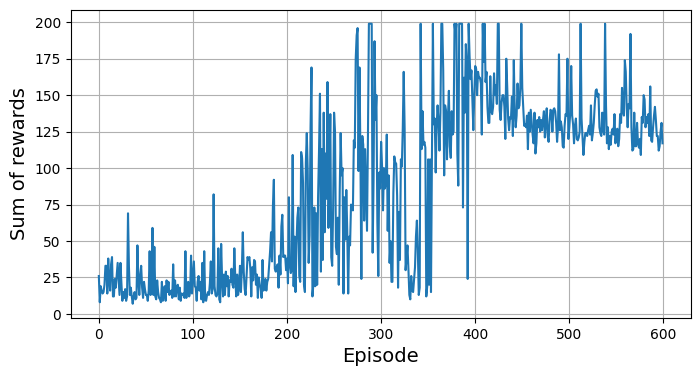

In [74]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

## Fixed Q-Value Targets

In [75]:
tf.random.set_seed(42)
input_shape = [4]
n_outputs = 2

In [76]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

In [77]:
target = tf.keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [78]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

In [79]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = target.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated

    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [80]:
for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}", end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
        
    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())
        
model.set_weights(best_weights)

Episode: 600, Steps: 61, eps: 0.0100

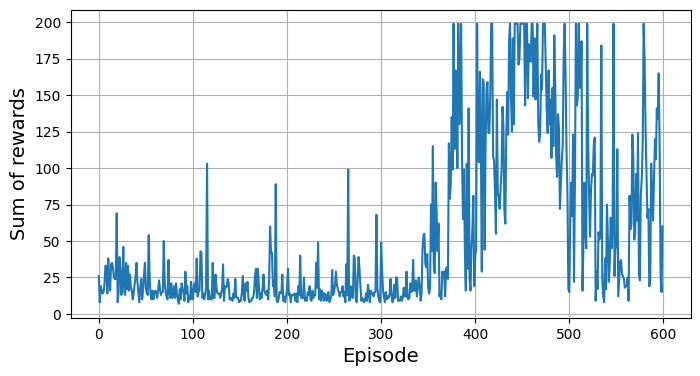

In [81]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

## Double DQN

In [20]:
import gymnasium as gym
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [21]:
tf.random.set_seed(42)
# input_shape = [4]
# n_outputs = 2

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

target = tf.keras.models.clone_model(model)  # clone the model's architecture
target.set_weights(model.get_weights())  # copy the weights

In [22]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

In [23]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    
    next_Q_values = model.predict(next_states, verbose=0)  # ≠ target.predict()
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask).sum(axis=1)
    
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated

    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [24]:
from collections import deque
replay_buffer = deque(maxlen=2000)

In [28]:
for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}", end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
        
    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 6, Steps: 21, eps: 0.990

InternalError: Graph execution error:

Detected at node 'sequential_1/dense_3/MatMul' defined at (most recent call last):
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\a.seong\AppData\Local\Temp\ipykernel_9280\1693509772.py", line 5, in <module>
      obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
    File "C:\Users\a.seong\AppData\Local\Temp\ipykernel_9280\326399654.py", line 17, in play_one_step
      action = epsilon_greedy_policy(state, epsilon)
    File "C:\Users\a.seong\AppData\Local\Temp\ipykernel_9280\326399654.py", line 5, in epsilon_greedy_policy
      Q_values = model.predict(state[np.newaxis], verbose=0)[0]
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\a.seong\Anaconda3\envs\p39_tfgpu210_cuda112\lib\site-packages\keras\layers\core\dense.py", line 241, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'sequential_1/dense_3/MatMul'
cublas error
	 [[{{node sequential_1/dense_3/MatMul}}]] [Op:__inference_predict_function_402]

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [110]:
import gymnasium as gym
frames = []
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [108]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(epsilon_greedy_policy)

DependencyNotInstalled: pygame is not installed, run `pip install gymnasium[classic-control]`

In [104]:
!pip install gymnasium[classic-control]

   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.7 MB 5.7 MB/s eta 0:00:02
   -- ------------------------------------- 0.7/10.7 MB 7.5 MB/s eta 0:00:02
   ---- ----------------------------------- 1.2/10.7 MB 8.6 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/10.7 MB 9.4 MB/s eta 0:00:01
   -------- ------------------------------- 2.3/10.7 MB 9.8 MB/s eta 0:00:01
   ---------- ----------------------------- 2.8/10.7 MB 10.6 MB/s eta 0:00:01
   ------------ --------------------------- 3.3/10.7 MB 10.5 MB/s eta 0:00:01
   -------------- ------------------------- 3.8/10.7 MB 10.6 MB/s eta 0:00:01
   ---------------- ----------------------- 4.3/10.7 MB 10.6 MB/s eta 0:00:01
   ------------------ --------------------- 4.8/10.7 MB 10.7 MB/s eta 0:00:01
   ------------------- -------------------- 5.3/10.7 MB 10.7 MB/s eta 0:00:01
   --------------------- ------------------ 5.9/10.7 MB 10.7 MB/s eta 0:00:01


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pygame

pygame 2.6.0 (SDL 2.28.4, Python 3.9.19)
Hello from the pygame community. https://www.pygame.org/contribute.html
